In [50]:
import logging
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import(
    train_test_split,
    cross_validate,
    cross_val_predict,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import(
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler
)
from sklearn.ensemble import(
    GradientBoostingClassifier
)
from sklearn.metrics import(
    accuracy_score,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    DetCurveDisplay
)
from sklearn.inspection import(
    permutation_importance
)
from sklearn.compose import ColumnTransformer
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

In [7]:
df_raw = pd.read_csv("../data/raw/ai4i2020.csv")

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [9]:
df_raw.sample(10, random_state=2025)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
6448,6449,H35862,H,300.7,310.2,1877,24.8,64,0,0,0,0,0,0
3544,3545,M18404,M,301.9,310.9,1483,37.0,35,0,0,0,0,0,0
3904,3905,H33318,H,302.2,311.1,1426,50.6,101,0,0,0,0,0,0
9739,9740,L56919,L,298.9,310.0,1515,42.9,170,0,0,0,0,0,0
8295,8296,L55475,L,298.9,310.4,1739,26.3,30,0,0,0,0,0,0
3600,3601,L50780,L,301.7,310.5,1523,34.7,181,0,0,0,0,0,0
1457,1458,L48637,L,299.0,310.3,1475,42.4,93,0,0,0,0,0,0
6938,6939,L54118,L,300.7,311.2,1452,44.4,33,0,0,0,0,0,0
984,985,L48164,L,296.3,307.1,1419,48.6,142,0,0,0,0,0,0
9586,9587,L56766,L,299.4,310.6,1348,54.5,22,0,0,0,0,0,0


#### **Data Dictionary**

|Name|Description|Type|Units|
|----|-----------|----|-----|
|UDI|Row ID|Int|None|
|Product ID|letters L, M, or H for low as product quality variants and a variant-specific SN.|Object|None|
|Type|letters L, M, or H for low as product quality variants|Object|None|
|Air temperature [K]|Temperature in Kelvin|Float|K|
|Process temperature [K]|Process temperature in Kelvin|Float|K|
|Rotational speed [rpm]|calculated from a power of 2860 W|Int|rpm|
|Torque [Nm]|torque values|Float|Nm|
|Tool wear [min]|minutes of tool wear to the used tool in the process|Int|min|
|Machine failure|label that indicates, whether the machine has failed in this particular datapoint.|Bool|None|
|TWF|tool wear failure|Bool|None|
|HDF|heat dissipation failure|Bool|None|
|PWF|power failure|Bool|None|
|OSF|overstrain failure|Bool|None|
|RNF|random failures|Bool|None|

#### **2. Data preprocessing**

In [15]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.replace(" ","_").str.replace("[","").str.replace("]","").str.lower()
df_baking = df_baking.drop(columns=["udi","product_id"])
df_baking["type"] = df_baking["type"].astype("category")
df_baking["machine_failure"] = df_baking["machine_failure"].apply(lambda x: "yes" if x==1 else "no") #Clase positiva es yes porque =1
df_baking["machine_failure"] = df_baking["machine_failure"].astype("category")
df_baking = df_baking.drop(columns=["twf","hdf","pwf","osf","rnf"])
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   type                   10000 non-null  category
 1   air_temperature_k      10000 non-null  float64 
 2   process_temperature_k  10000 non-null  float64 
 3   rotational_speed_rpm   10000 non-null  int64   
 4   torque_nm              10000 non-null  float64 
 5   tool_wear_min          10000 non-null  int64   
 6   machine_failure        10000 non-null  category
dtypes: category(2), float64(3), int64(2)
memory usage: 410.5 KB


#### **3. EDA**

In [17]:
df_train,df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=2025,
    stratify=df["machine_failure"]
)
df_train,df_val = train_test_split(
    df_train,
    test_size=0.2,
    random_state=2025,
    stratify=df_train['machine_failure']
)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6400 entries, 7538 to 7522
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   type                   6400 non-null   category
 1   air_temperature_k      6400 non-null   float64 
 2   process_temperature_k  6400 non-null   float64 
 3   rotational_speed_rpm   6400 non-null   int64   
 4   torque_nm              6400 non-null   float64 
 5   tool_wear_min          6400 non-null   int64   
 6   machine_failure        6400 non-null   category
dtypes: category(2), float64(3), int64(2)
memory usage: 312.8 KB


In [19]:
display(df_train.describe(include="number").T)
display(df_train.describe(include="category").T)

,count,mean,std,min,25%,50%,75%,max
air_temperature_k,6400.0,299.962672,1.999068,295.3,298.3,300.0,301.5,304.5
process_temperature_k,6400.0,309.978125,1.483554,305.7,308.8,310.0,311.0,313.8
rotational_speed_rpm,6400.0,1537.942656,177.971692,1183.0,1424.0,1504.0,1613.0,2886.0
torque_nm,6400.0,39.993016,9.888766,3.8,33.2,40.1,46.7,75.4
tool_wear_min,6400.0,108.214062,63.507630,0.0,54.0,108.0,162.0,253.0


,count,unique,top,freq
type,6400,3,L,3874
machine_failure,6400,2,no,6183


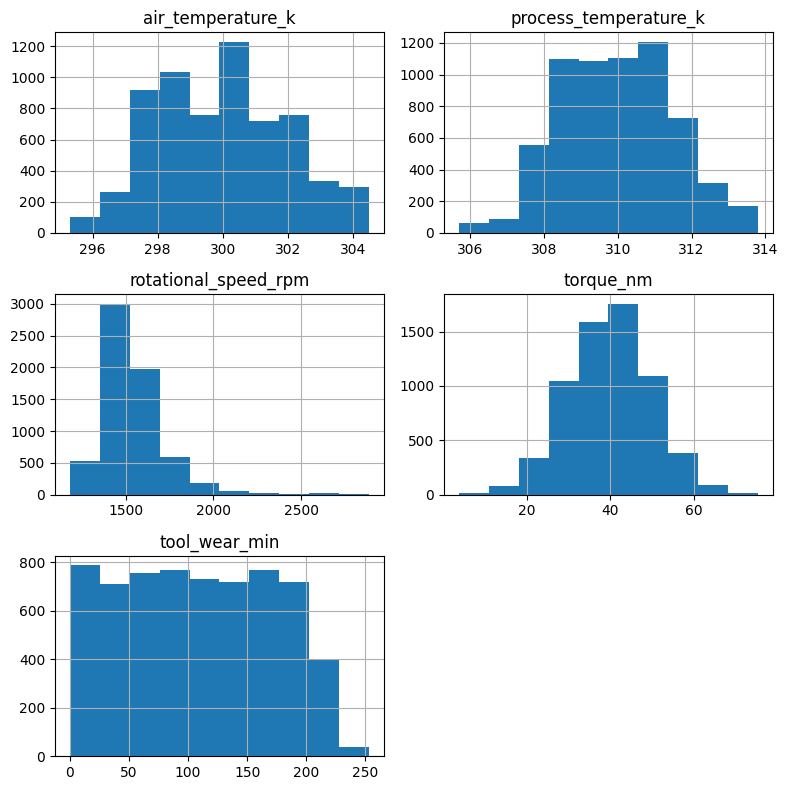

In [20]:
df_train.hist(figsize=(8,8))
plt.tight_layout()
plt.show()

/workspaces/Class27-Gradient-Boosting/EDA-env/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/workspaces/Class27-Gradient-Boosting/EDA-env/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/workspaces/Class27-Gradient-Boosting/EDA-env/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_

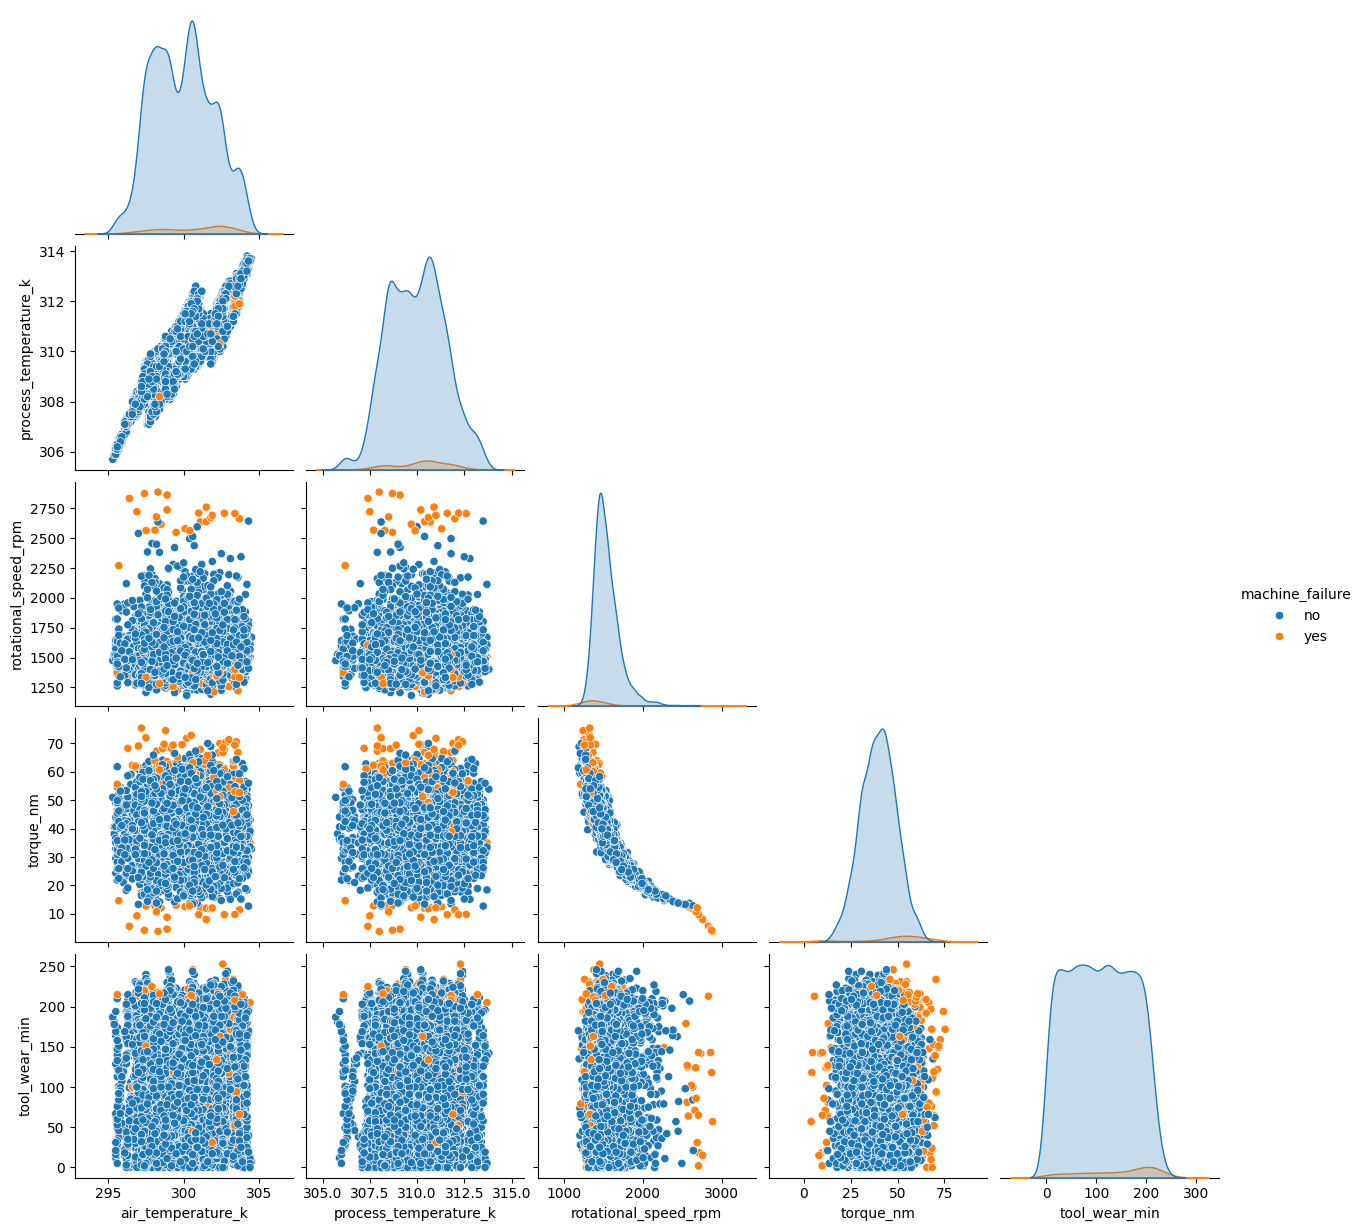

In [24]:
sns.pairplot(df_train,hue="machine_failure",corner=True)
plt.show()

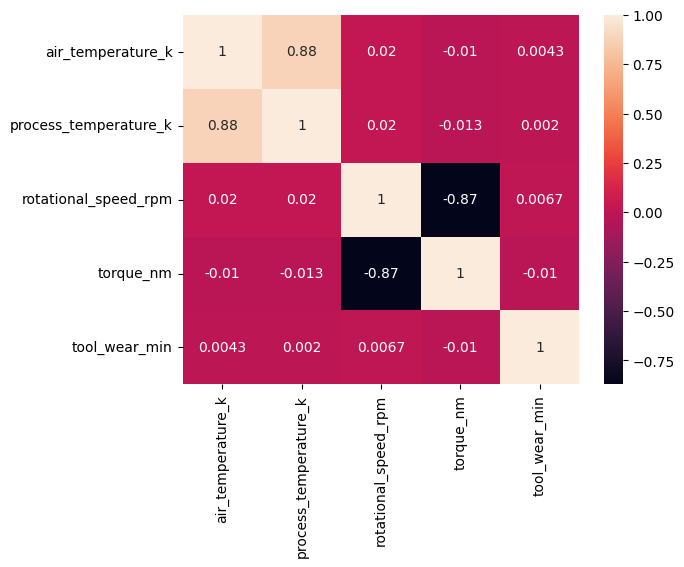

In [26]:
sns.heatmap(data=df_train.select_dtypes("number").corr(),annot=True)
plt.show()

#### **4. Machine Learning**

In [29]:
X_train = df_train.drop(columns=["machine_failure"]).copy()
y_train = df_train["machine_failure"].copy()
X_val = df_val.drop(columns=["machine_failure"]).copy()
y_val = df_val["machine_failure"].copy()
X_test = df_test.drop(columns=["machine_failure"]).copy()
y_test = df_test["machine_failure"].copy()

In [30]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [34]:
cat_cols = X_train.select_dtypes("category").columns
num_cols = X_train.select_dtypes("number").columns
cat_proc = Pipeline([
    ("one_hot",OneHotEncoder(drop="first"))
])
num_proc = Pipeline([
    ("scaler",MinMaxScaler())
])
processor = ColumnTransformer([
    ("cat",cat_proc,cat_cols),
    ("num",num_proc,num_cols)
])

In [40]:
clf_gbp = Pipeline([
    ("processor",processor),
    ("gb",GradientBoostingClassifier(random_state=2025))
])
clf_gbp_cv = GridSearchCV(
    clf_gbp,
    param_grid={
        "gb__max_depth":[3,5,7,9],
        "gb__n_estimators":[20,30,50,100],
        "gb__min_samples_split":[2,4,6,8,10],
        "gb__min_samples_leaf":[1,3,5,7,9]
    },
    cv=5,
    scoring="f1",
    n_jobs=-1
)

In [41]:
clf_gbp_cv.fit(X_train,y_train_enc)
clf_gbp_cv.best_params_

{'gb__max_depth': 9,
 'gb__min_samples_leaf': 3,
 'gb__min_samples_split': 10,
 'gb__n_estimators': 100}

accuracy: 0.99
f1_score: 0.79
              precision    recall  f1-score   support

          no       0.99      1.00      0.99      1546
         yes       0.90      0.70      0.79        54

    accuracy                           0.99      1600
   macro avg       0.95      0.85      0.89      1600
weighted avg       0.99      0.99      0.99      1600



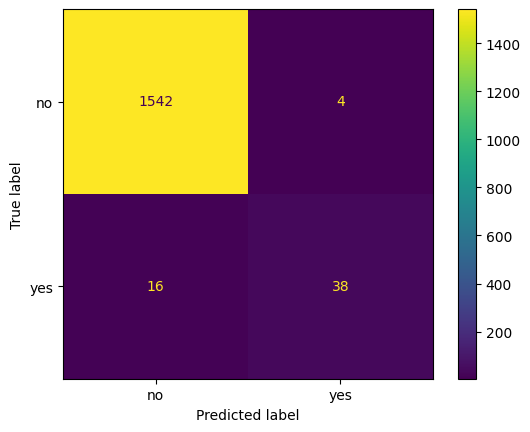

In [44]:
y_hat_val = clf_gbp_cv.predict(X_val)
print(f'accuracy: {accuracy_score(y_val_enc,y_hat_val):.2f}')
print(f'f1_score: {f1_score(y_val_enc,y_hat_val):.2f}')
print(classification_report(y_val_enc,y_hat_val,target_names= label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_val_enc, y_hat_val, display_labels= label_encoder.classes_)
plt.show()

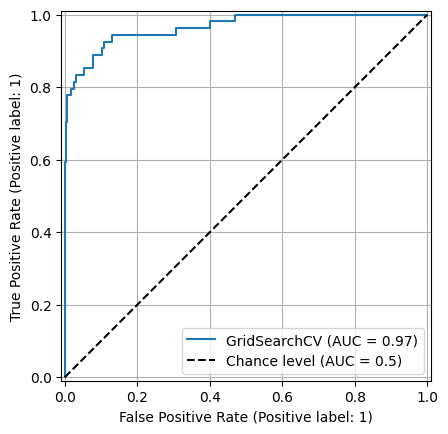

In [49]:
RocCurveDisplay.from_estimator(
    clf_gbp_cv,X_val,y_val_enc,plot_chance_level=True
)
plt.grid(True)
plt.show()

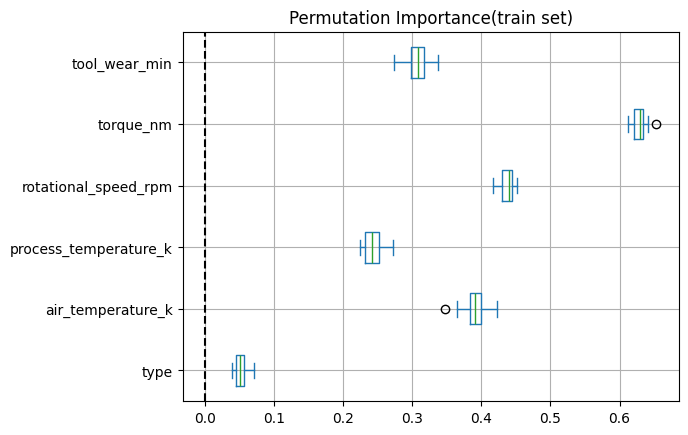

In [43]:
importance = permutation_importance(clf_gbp_cv,X_train,y_train_enc,n_repeats=25,random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,color="k",linestyle="--")
ax.set_title("Permutation Importance(train set)")
ax.grid(True)
plt.show()

In [52]:
y_hat_test = clf_gbp_cv.predict(X_test)
print(f'accuracy: {accuracy_score(y_test_enc,y_hat_test):.2f}')
print(f'f1_score: {f1_score(y_test_enc,y_hat_test):.2f}')
print(f'precision: {precision_score(y_test_enc,y_hat_test):.2f}')
print(f'recall: {recall_score(y_test_enc,y_hat_test):.2f}')

accuracy: 0.99
f1_score: 0.81
precision: 0.92
recall: 0.72


#### **5. Model Saving**

In [46]:
model_dict = {
    "model":clf_gbp_cv,
    "predictors":X_train.columns,
    "algorithm_name":"Gradient Boosting Classifier",
    "metrics":"accuracy:0.99, f1 score:0.79",
    "author":"José Rosales",
    "classes":"0:no,1:yes"
}

In [47]:
try:
    with open("../models/maintenance_prediction_gb_model.pkl","wb") as file:
        pickle.dump(model_dict,file)
except Exception as e:
    logger.error(f"an error has occured: {e}")